# Gravity Spy Machine Learning Classifications of LIGO Glitches from Observing Runs O1, O2, O3a, and O3b

这个数据集名为 "Gravity Spy Machine Learning Classifications of LIGO Glitches from Observing Runs O1, O2, O3a, and O3b"，由Glanzer等人在2021年发布 (https://zenodo.org/record/5649212)。

数据集包含了LIGO观测运行O1, O2, O3a和O3b期间，Gravity Spy机器学习模型对LIGO故障的所有分类。

在这个教程中，我们将使用其中的 H1_O1 和 L1_O1 数据集。这些数据集包含了Omicron触发管道识别的所有噪声事件的分类，其中Omicron识别的信噪比超过7.5，噪声事件的峰值频率在10 Hz和2048 Hz之间。

每个数据集中的列包括：

- Omicron 流水线的信号元数据（如event_time, ifo, peak_time, peak_time_ns, start_time, start_time_ns, duration, peak_frequency, central_freq, bandwidth, channel, amplitude, snr, q_value）。
- 每个 glitch 在数据集中的唯一标识符（gravityspy_id）。
- 机器学习对每个故障属于特定Gravity Spy类的置信度（如1400Ripples, 1080Lines, Air_Compressor, Blip, Chirp, Extremely_Loud, Helix, Koi_Fish, Light_Modulation, Low_Frequency_Burst, Low_Frequency_Lines, No_Glitch, None_of_the_Above, Paired_Doves, Power_Line, Repeating_Blips, Scattered_Light, Scratchy, Tomte, Violin_Mode, Wandering_Line, Whistle）。
- 机器学习预测的每个 glitch 的标签和分类的置信度（ml_label, ml_confidence）。
- 每个 glitch 的公开可用的 [Omega scan](https://en.wikipedia.org/wiki/Constant-Q_transform) 的链接（url1, url2, url3, url4）。

我们将使用这些数据来搭建和训练分类模型。

# Download data

In [1]:
# !wget https://zenodo.org/records/5649212/files/H1_O1.csv -P data/
# !wget https://zenodo.org/records/5649212/files/L1_O1.csv -P data/

# Load libs

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# !pip install gwpy
from gwpy.time import to_gps, from_gps

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, ShuffleSplit, ParameterGrid, StratifiedKFold


# Load data

In [159]:
df = pd.concat([
    pd.read_csv('data/H1_O1.csv'),
    pd.read_csv('data/L1_O1.csv')
])

cols = ['event_time', 'ifo', 'peak_time', 'peak_time_ns', 'start_time', 'start_time_ns',
        'duration', 'peak_frequency', 'central_freq', 'bandwidth', 'snr', 
        'amplitude', 'ml_label', 'ml_confidence']
df = df[cols]
df = df[df['ml_confidence'] >= 0.95]
df = df.reset_index().drop('index', axis=1)
df

,event_time,ifo,peak_time,peak_time_ns,start_time,start_time_ns,duration,peak_frequency,central_freq,bandwidth,snr,amplitude,ml_label,ml_confidence
0,1.133747e+09,H1,1133747480,875000000,1133747479,625000000,3.12500,23.161011,3083.450439,6125.699219,12.31222,9.112720e-22,Scattered_Light,0.999992
1,1.133139e+09,H1,1133138521,980957031,1133138521,937500000,0.12500,262.064606,1576.186646,3022.359619,15.72605,2.482060e-22,Blip,0.999553
2,1.131777e+09,H1,1131777198,383789062,1131777196,445312023,3.05469,111.128151,281.727661,546.868347,8.31163,1.555730e-22,Blip,0.993591
3,1.133107e+09,H1,1133106912,958983898,1133106912,937500000,0.12500,89.676369,201.923874,319.184143,11.29298,3.454280e-22,Blip,0.998819
4,1.132660e+09,H1,1132659628,687500000,1132659627,500000000,2.50000,10.771410,3876.945312,7741.605469,9.74269,1.326820e-19,Low_Frequency_Lines,0.984899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25845,1.137220e+09,L1,1137219636,326172113,1137219636,250000000,0.10547,1527.022095,1802.779419,1581.367554,12.79415,5.758980e-22,1400Ripples,0.999278
25846,1.130257e+09,L1,1130256563,31250000,1130256562,875000000,0.50000,64.891693,64.202530,8.083960,8.34971,1.164350e-22,Power_Line,0.999904
25847,1.131414e+09,L1,1131413524,687500000,1131413524,0,1.00000,65.531433,66.881851,5.131030,7.70147,9.419780e-23,Power_Line,0.999980
25848,1.129983e+09,L1,1129982991,312500000,1129982988,750000000,3.50000,11.519660,3979.047363,7942.870605,14.02844,7.782930e-19,Low_Frequency_Lines,0.992579


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25850 entries, 0 to 25849
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event_time      25850 non-null  float64
 1   ifo             25850 non-null  object 
 2   peak_time       25850 non-null  int64  
 3   peak_time_ns    25850 non-null  int64  
 4   start_time      25850 non-null  int64  
 5   start_time_ns   25850 non-null  int64  
 6   duration        25850 non-null  float64
 7   peak_frequency  25850 non-null  float64
 8   central_freq    25850 non-null  float64
 9   bandwidth       25850 non-null  float64
 10  snr             25850 non-null  float64
 11  amplitude       25850 non-null  float64
 12  ml_label        25850 non-null  object 
 13  ml_confidence   25850 non-null  float64
dtypes: float64(8), int64(4), object(2)
memory usage: 2.8+ MB


In [161]:
df.ml_label.value_counts()

ml_label
Low_Frequency_Lines    6592
Low_Frequency_Burst    4823
Scattered_Light        3020
Blip                   2690
Power_Line             1888
Scratchy               1673
No_Glitch              1173
1400Ripples            1159
Koi_Fish                768
Light_Modulation        484
Repeating_Blips         314
Whistle                 310
Extremely_Loud          275
Helix                   241
Violin_Mode             125
Paired_Doves             80
Air_Compressor           77
Chirp                    59
Tomte                    36
Wandering_Line           36
None_of_the_Above        25
1080Lines                 2
Name: count, dtype: int64

In [162]:
target_labels = [label for label in pd.unique(df.ml_label) if label not in ['None_of_the_Above', '1080Lines', 'No_Glitch']]
df = pd.concat([df[df.ml_label == label]
                         for label in target_labels])
df.shape

(24650, 14)

In [163]:
df.ml_label.value_counts()

ml_label
Low_Frequency_Lines    6592
Low_Frequency_Burst    4823
Scattered_Light        3020
Blip                   2690
Power_Line             1888
Scratchy               1673
1400Ripples            1159
Koi_Fish                768
Light_Modulation        484
Repeating_Blips         314
Whistle                 310
Extremely_Loud          275
Helix                   241
Violin_Mode             125
Paired_Doves             80
Air_Compressor           77
Chirp                    59
Tomte                    36
Wandering_Line           36
Name: count, dtype: int64

# Data prepararing + Feature engineering

In [164]:
%%time
# 创建 ID
df.loc[:, 'id'] = df.event_time.map(lambda x: from_gps(x).strftime('g%y%m%d_%H%M%S+')+str(int(from_gps(x).microsecond/1000)).zfill(3))

CPU times: user 17.6 s, sys: 522 ms, total: 18.1 s
Wall time: 17.4 s


In [193]:
# df

In [165]:
%%time
# 对时间特征处理，取出关键信息
df.loc[:, 'peak_time_fullgps'] = df.peak_time + 1e-9*df.peak_time_ns
df.loc[:, 'start_time_fullgps'] = df.start_time + 1e-9*df.start_time_ns
df.loc[:, 'peak_time'] = df.peak_time_fullgps.map(lambda x: from_gps(x))
df.loc[:, 'start_time'] = df.start_time_fullgps.map(lambda x: from_gps(x))

for target_time in ['peak_time', 'start_time']:
    df.loc[:, f'{target_time}_day'] = df[f'{target_time}'].dt.day
    df.loc[:, f'{target_time}_year'] = df[f'{target_time}'].dt.year
    df.loc[:, f'{target_time}_month'] = df[f'{target_time}'].dt.month
    df.loc[:, f'{target_time}_hour'] = df[f'{target_time}'].dt.hour
    df.loc[:, f'{target_time}_minute'] = df[f'{target_time}'].dt.minute
    df.loc[:, f'{target_time}_second'] = df[f'{target_time}'].dt.second
    df.loc[:, f'{target_time}_microsecond'] = df[f'{target_time}'].dt.microsecond
    df.loc[:, f'{target_time}_day_of_week'] = df[f'{target_time}'].dt.day_of_week
    df.loc[:, f'{target_time}_day_of_year'] = df[f'{target_time}'].dt.day_of_year
    df.loc[:, f'{target_time}_weekday'] = df[f'{target_time}'].dt.weekday

CPU times: user 17 s, sys: 480 ms, total: 17.5 s
Wall time: 16.9 s


In [166]:
# 对标签类别进行编码
class_le = LabelEncoder()
df.loc[:, 'ml_label'] = class_le.fit_transform(df['ml_label'].values)
df.loc[:, 'label'] = df.ml_label.astype('int')

In [167]:
# 去掉不需要的特征列；把 ifo 特征进行独热向量编码
df = df.drop(['event_time', 'peak_time', 'peak_time_ns', 'start_time', 'start_time_ns', 'ml_confidence', 'ml_label'], axis=1)
df = pd.concat([df, pd.get_dummies(df[['ifo']], dtype='float')], axis=1).drop('ifo', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24650 entries, 0 to 25845
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   duration                24650 non-null  float64
 1   peak_frequency          24650 non-null  float64
 2   central_freq            24650 non-null  float64
 3   bandwidth               24650 non-null  float64
 4   snr                     24650 non-null  float64
 5   amplitude               24650 non-null  float64
 6   id                      24650 non-null  object 
 7   peak_time_fullgps       24650 non-null  float64
 8   start_time_fullgps      24650 non-null  float64
 9   peak_time_day           24650 non-null  int32  
 10  peak_time_year          24650 non-null  int32  
 11  peak_time_month         24650 non-null  int32  
 12  peak_time_hour          24650 non-null  int32  
 13  peak_time_minute        24650 non-null  int32  
 14  peak_time_second        24650 non-null  int

# Train data + test data

In [18]:
columns = df.drop(['label', 'id'], axis=1).columns.tolist()
X, y = df.drop(['label', 'id'], axis=1), df.label

# 切分训练集和测试集
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((17255, 30), (17255,), (7395, 30), (7395,))

In [86]:
# 标准化
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# Model: Logistic Regression

In [20]:
# 小试牛刀
lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.7035641842944074
Test accuracy: 0.7207572684246112


# Model: Random Forest

In [22]:
%%time
# 随机森林玩一下！看看特征的重要性
forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)
forest.fit(X_train_std, y_train)

CPU times: user 15min 17s, sys: 17.4 s, total: 15min 35s
Wall time: 41.2 s


RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)

In [23]:
# 准确率直接干翻逻辑回归！但是显然过拟合严重。。。
print('Training accuracy:', forest.score(X_train_std, y_train))
print('Test accuracy:', forest.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 0.9245436105476673


 1) peak_frequency                 0.251434
 2) amplitude                      0.142417
 3) duration                       0.100266
 4) snr                            0.084439
 5) start_time_fullgps             0.050502
 6) peak_time_fullgps              0.050324
 7) central_freq                   0.041764
 8) bandwidth                      0.041271
 9) peak_time_day_of_year          0.022656
10) start_time_day_of_year         0.022510
11) ifo_H1                         0.018443
12) ifo_L1                         0.018280
13) peak_time_day                  0.013818
14) start_time_day                 0.013731
15) peak_time_microsecond          0.013493
16) start_time_hour                0.011752
17) peak_time_hour                 0.011705
18) peak_time_minute               0.010069
19) start_time_minute              0.010039
20) peak_time_second               0.009586
21) start_time_second              0.009572
22) start_time_microsecond         0.008237
23) start_time_day_of_week      

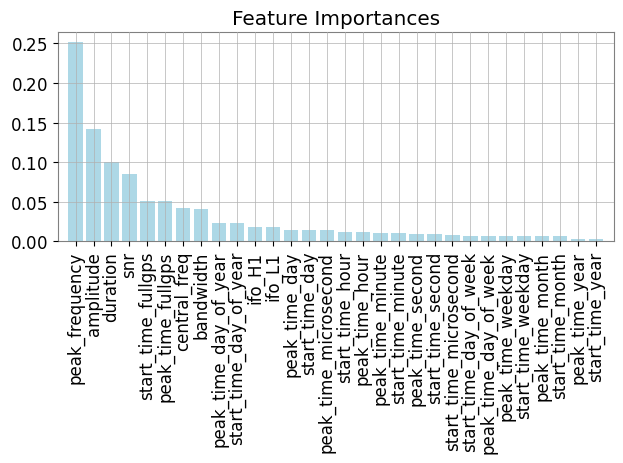

In [24]:
feat_labels = columns
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
    
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           np.array(feat_labels)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [25]:
# 挑选出明显重要性强的 8 个特征
sfm = SelectFromModel(forest, threshold=0.03, prefit=True)
X_train_std_selected = sfm.transform(X_train_std)
X_test_std_selected = sfm.transform(X_test_std)

X_train_std_selected.shape

(17255, 8)

In [140]:
%%time
# 用这 8 个重要性强的特征再重新训练随机森林模型
forest_selected = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)
forest_selected.fit(X_train_std_selected, y_train)

CPU times: user 13min 44s, sys: 15.6 s, total: 14min
Wall time: 41.2 s


RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)

In [27]:
# 结果仅用这 8 个特征训练的模型，性能依旧杠杠的！
print('Training accuracy:', forest_selected.score(X_train_std_selected, y_train))
print('Test accuracy:', forest_selected.score(X_test_std_selected, y_test))

Training accuracy: 1.0
Test accuracy: 0.9225152129817444


In [40]:
X_combined_std_selected = np.concatenate([X_train_std_selected, X_test_std_selected])
y_combined = np.concatenate([y_train, y_test])

In [41]:
%%time
# 再交叉验证一下
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=5)
model = RandomForestClassifier(n_estimators=10000, random_state=0,)
result = cross_val_score(model, X_combined_std_selected, y_combined, cv=shuffle_split, n_jobs=-1)
print(result.mean())

0.9157160243407707
CPU times: user 266 ms, sys: 28 s, total: 28.3 s
Wall time: 5min 29s


In [42]:
%%time
# 再交叉验证一下
stratified_split = StratifiedKFold(n_splits=5)
model = RandomForestClassifier(n_estimators=10000, random_state=0,)
result = cross_val_score(model, X_combined_std_selected, y_combined, cv=stratified_split, n_jobs=-1)
print(result.mean())

0.9214604462474645
CPU times: user 426 ms, sys: 26.5 s, total: 26.9 s
Wall time: 8min 28s


# Model: SVM

In [43]:
# 接下来对 8 个特征下的训练数据，我们就在强大的 SVM 模型下调参，处理一下过拟合问题，看性能是不是还能再提升？
print(f"Shape of training set: {X_train_std_selected.shape}   shape of test set: {X_test_std_selected.shape}")

Shape of training set: (17255, 8)   shape of test set: (7395, 8)


In [44]:
%%time
best_score = 0

for gamma in tqdm([0.001, 0.01, 0.1, 1, 10, 100]):
    for C in tqdm([0.001, 0.01, 0.1, 1, 10, 100], desc=f'gamma={gamma}'):
        # for each combination of parameters
        # train an SVC
        svm_selected = SVC(gamma=gamma, C=C)
        svm_selected.fit(X_train_std_selected, y_train)
        # evaluate the SVC on the test set 
        score = svm_selected.score(X_test_std_selected, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("best score: ", best_score)
print("best parameters: ", best_parameters)

100%|██████████| 6/6 [14:24<00:00, 144.00s/it]

best score:  0.8563894523326572
best parameters:  {'C': 100, 'gamma': 0.1}
CPU times: user 14min 21s, sys: 3.01 s, total: 14min 24s
Wall time: 14min 24s


In [45]:
svm_selected = SVC(**best_parameters)
svm_selected.fit(X_train_std_selected, y_train)

SVC(C=100, gamma=0.1)

In [46]:
print('Training accuracy:', svm_selected.score(X_train_std_selected, y_train))
print('Test accuracy:', svm_selected.score(X_test_std_selected, y_test))

Training accuracy: 0.866067806432918
Test accuracy: 0.8563894523326572


# Test on O2

In [49]:
# !wget https://zenodo.org/records/5649212/files/H1_O2.csv -P data/
# !wget https://zenodo.org/records/5649212/files/L1_O2.csv -P data/

In [168]:
df_O2 = pd.concat([
    pd.read_csv('data/H1_O2.csv'),
    pd.read_csv('data/L1_O2.csv')
])

cols = ['event_time', 'ifo', 'peak_time', 'peak_time_ns', 'start_time', 'start_time_ns',
        'duration', 'peak_frequency', 'central_freq', 'bandwidth', 'snr', 
        'amplitude', 'ml_label', 'ml_confidence']
df_O2 = df_O2[cols]
df_O2 = df_O2[df_O2['ml_confidence'] >= 0.95]
df_O2 = df_O2.reset_index().drop('index', axis=1)
df_O2

,event_time,ifo,peak_time,peak_time_ns,start_time,start_time_ns,duration,peak_frequency,central_freq,bandwidth,snr,amplitude,ml_label,ml_confidence
0,1.165768e+09,H1,1165768097,644531011,1165768097,570312023,0.08594,1096.148560,1083.121948,57.869942,7.53510,1.367110e-22,1080Lines,0.995903
1,1.164905e+09,H1,1164905171,410156011,1164905171,367187023,0.06250,1075.608765,1145.550537,268.463440,8.44360,1.611410e-22,1080Lines,0.999650
2,1.168366e+09,H1,1168365843,900389909,1168365843,527343034,0.40234,1082.743164,1065.330444,487.726471,9.64410,2.413800e-22,1080Lines,1.000000
3,1.165462e+09,H1,1165461901,597656011,1165461901,570312023,0.16406,1096.148560,1093.113159,77.852058,7.80988,1.788780e-22,1080Lines,0.996695
4,1.166205e+09,H1,1166204777,933593034,1166204777,735351085,0.45215,1096.148560,4480.900879,6939.164062,10.02408,2.387170e-22,1080Lines,0.999990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80001,1.168467e+09,L1,1168467437,875000000,1168467437,0,1.50000,15.622150,3085.205811,6147.033203,7.52634,6.186550e-21,Low_Frequency_Lines,0.993277
80002,1.173242e+09,L1,1173242444,187500000,1173242444,0,1.25000,68.606911,65.339828,68.975723,7.94020,6.658610e-23,Power_Line,0.979834
80003,1.170262e+09,L1,1170261586,336425065,1170261586,328125000,0.01562,211.476593,458.770447,787.527283,9.08770,4.665710e-23,Blip,0.998494
80004,1.168568e+09,L1,1168567671,375000000,1168567670,500000000,2.03027,35.723122,3816.616943,7588.744141,13.42574,1.623810e-22,Scattered_Light,0.999996


In [169]:
set(pd.unique(df_O2.ml_label)) - set(target_labels)  # 除了我们想去掉的，没有额外的新glitch类型

{'1080Lines', 'No_Glitch', 'None_of_the_Above'}

In [170]:
target_labels_O2 = [label for label in pd.unique(df_O2.ml_label) if label not in ['None_of_the_Above', '1080Lines', 'No_Glitch']]
df_O2 = pd.concat([df_O2[df_O2.ml_label == label]
                         for label in target_labels_O2])
df_O2.shape

(50810, 14)

In [171]:
df_O2.ml_label.value_counts()

ml_label
Low_Frequency_Lines    16714
Blip                   11122
Scattered_Light        10132
Koi_Fish                3369
Low_Frequency_Burst     2249
Whistle                 1551
Extremely_Loud          1537
Power_Line              1433
Scratchy                1094
Repeating_Blips          969
Tomte                    188
1400Ripples              169
Violin_Mode              159
Light_Modulation          54
Wandering_Line            25
Helix                     20
Paired_Doves              14
Air_Compressor            10
Chirp                      1
Name: count, dtype: int64

In [172]:
# 只要那 8 个特征即可
np.array(feat_labels)[indices[:8]]

array(['peak_frequency', 'amplitude', 'duration', 'snr',
       'start_time_fullgps', 'peak_time_fullgps', 'central_freq',
       'bandwidth'], dtype='<U22')

In [173]:
%%time
# 创建 ID
df_O2.loc[:, 'id'] = df_O2.event_time.map(lambda x: from_gps(x).strftime('g%y%m%d_%H%M%S+')+str(int(from_gps(x).microsecond/1000)).zfill(3))
# 对时间特征处理，取出关键信息
df_O2.loc[:, 'peak_time_fullgps'] = df_O2.peak_time + 1e-9*df_O2.peak_time_ns
df_O2.loc[:, 'start_time_fullgps'] = df_O2.start_time + 1e-9*df_O2.start_time_ns

CPU times: user 35.9 s, sys: 992 ms, total: 36.9 s
Wall time: 35.6 s


In [174]:
# 对标签类别进行编码
# Note: 要用上 O1 数据里 fit 出来的 class_le
df_O2.loc[:, 'ml_label'] = class_le.fit_transform(df_O2['ml_label'].values)
df_O2.loc[:, 'label'] = df_O2.ml_label.astype('int')

In [175]:
# 去掉不需要的特征列；把 ifo 特征进行独热向量编码
df_O2 = df_O2.drop(['event_time', 'peak_time', 'peak_time_ns', 'start_time', 'start_time_ns', 'ml_confidence', 'ml_label'], axis=1)
df_O2 = pd.concat([df_O2, pd.get_dummies(df_O2[['ifo']], dtype='float')], axis=1).drop('ifo', axis=1)
df_O2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50810 entries, 7 to 65930
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   duration            50810 non-null  float64
 1   peak_frequency      50810 non-null  float64
 2   central_freq        50810 non-null  float64
 3   bandwidth           50810 non-null  float64
 4   snr                 50810 non-null  float64
 5   amplitude           50810 non-null  float64
 6   id                  50810 non-null  object 
 7   peak_time_fullgps   50810 non-null  float64
 8   start_time_fullgps  50810 non-null  float64
 9   label               50810 non-null  int64  
 10  ifo_H1              50810 non-null  float64
 11  ifo_L1              50810 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 5.0+ MB


In [137]:
X_O2, y_O2 = df_O2[[col for col in df.columns.tolist() if col in np.array(feat_labels)[indices[:8]]]], df_O2.label.values

In [138]:
# 标准化
stdsc = StandardScaler()
X_std_O2 = stdsc.fit_transform(X_O2)

- 果然：”理想很美好，现实很骨感“

In [141]:
# 随机森林
print('O2 accuracy:', forest_selected.score(X_std_O2, y_O2))

O2 accuracy: 0.5638260185002952


In [142]:
# SVM
print('O2 accuracy:', svm_selected.score(X_std_O2, y_O2))

O2 accuracy: 0.605609132060618


In [143]:
# 切分训练集和测试集
X_train_O2, X_test_O2, y_train_O2, y_test_O2 = \
    train_test_split(X_O2, y_O2, test_size=0.3, random_state=0)
X_train_O2.shape, y_train_O2.shape, X_test_O2.shape, y_test_O2.shape

((35567, 8), (35567,), (15243, 8), (15243,))

- 可能是数据分布差异太大，稍微调整一下O1 和O2 的gps特征，然后分别在 O1 和 O2 上重新训练一波

In [179]:
modified_columns = (set(np.array(feat_labels)[indices[:8]]) | set(['peak_start_distance'])) - set(['peak_time_fullgps', 'start_time_fullgps'])
modified_columns
# 7个特征来搞事情

{'amplitude',
 'bandwidth',
 'central_freq',
 'duration',
 'peak_frequency',
 'peak_start_distance',
 'snr'}

In [180]:
temp = df[[col for col in df.columns.tolist()
              if col in np.array(feat_labels)[indices[:8]]]]
df.loc[:,'peak_start_distance'] = temp.peak_time_fullgps - temp.start_time_fullgps

df_modified = df[[col for col in df.columns.tolist()
                  if col in modified_columns]]
df_modified

,duration,peak_frequency,central_freq,bandwidth,snr,amplitude,peak_start_distance
0,3.12500,23.161011,3083.450439,6125.699219,12.31222,9.112720e-22,1.250000
5,1.12500,53.730080,42.504478,28.540449,8.83714,7.523970e-23,0.437500
10,1.75000,24.363270,3203.047363,6367.409668,11.79201,6.935220e-22,0.937500
11,1.12500,33.173901,43.625809,42.762009,9.65102,2.106870e-22,0.750000
13,3.37500,50.289051,2961.414307,5901.543945,20.92308,2.076380e-22,1.187500
...,...,...,...,...,...,...,...
25807,0.06641,1527.022095,2087.095215,1224.458984,10.76469,4.844820e-22,0.021484
25821,0.04688,1527.022095,1756.158569,562.585754,10.50213,5.606110e-22,0.025391
25823,0.03955,1527.022095,1765.836426,581.941406,9.30373,4.117320e-22,0.014160
25832,0.04688,1527.022095,1518.905151,81.143478,9.53593,4.382050e-22,0.017578


In [181]:
temp = df_O2[[col for col in df.columns.tolist()
              if col in np.array(feat_labels)[indices[:8]]]]
df_O2.loc[:,'peak_start_distance'] = temp.peak_time_fullgps - temp.start_time_fullgps
df_O2_modified = df_O2[[col for col in df_O2.columns.tolist()
                        if col in modified_columns]]
df_O2_modified

,duration,peak_frequency,central_freq,bandwidth,snr,amplitude,peak_start_distance
7,0.25000,211.476593,365.147858,645.632141,27.556669,1.619030e-22,0.112793
9,0.30859,170.653900,708.072815,1347.825195,20.646790,1.161990e-22,0.176758
10,6.00000,402.439423,3000.409668,5992.298828,9.500670,7.523580e-23,2.400634
13,0.07520,211.476593,2683.394531,5205.674805,9.551630,5.396630e-23,0.008301
15,0.08594,111.128151,178.368515,226.723389,8.450540,5.424690e-23,0.073242
...,...,...,...,...,...,...,...
55017,0.46289,48.249069,1213.019775,2357.718994,7.716150,7.590440e-23,0.330078
56670,0.50000,48.836180,49.305050,14.360080,8.428330,7.086710e-23,0.218750
60916,0.37500,47.974152,47.716240,11.182450,7.534050,6.698290e-23,0.156250
62350,0.50000,48.836182,3424.374756,6755.920410,7.964590,7.925360e-23,0.343750


In [182]:
X_O1, y_O1 = df_modified.values, df.label.values
X_O2, y_O2 = df_O2_modified.values, df_O2.label.values

In [184]:
# 标准化
stdsc = StandardScaler()
stdsc.fit(np.concatenate([X_O1, X_O2]))  # 大家一起标准化
X_std_O1 = stdsc.transform(X_O1)
X_std_O2 = stdsc.transform(X_O2)

In [185]:
%%time
# 用这 8 个重要性强的特征再重新训练随机森林模型
forest_O1_selected = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)
forest_O1_selected.fit(X_std_O1, y_O1)

forest_O2_selected = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)
forest_O2_selected.fit(X_std_O2, y_O2)

CPU times: user 52min 3s, sys: 46.2 s, total: 52min 49s
Wall time: 1min 54s


RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)

In [187]:
# 随机森林
print('Test on O1 accuracy using O1 RF model:', forest_O1_selected.score(X_std_O1, y_O1))
print('Test on O2 accuracy using O2 RF model:', forest_O2_selected.score(X_std_O2, y_O2))

Test on O1 accuracy using O1 RF model: 1.0
Test on O2 accuracy using O2 RF model: 1.0


In [188]:
# 随机森林
print('Test on O1 accuracy using O2 RF model:', forest_O2_selected.score(X_std_O1, y_O1))
print('Test on O2 accuracy using O1 RF model:', forest_O1_selected.score(X_std_O2, y_O2))

Test on O1 accuracy using O2 RF model: 0.7133468559837728
Test on O2 accuracy using O1 RF model: 0.8317850816768353


In [189]:
%%time
# 用这 8 个重要性强的特征再重新训练SVM模型
svm_O1_selected = SVC(**best_parameters)
svm_O1_selected.fit(X_std_O1, y_O1)

svm_O2_selected = SVC(**best_parameters)
svm_O2_selected.fit(X_std_O2, y_O2)

CPU times: user 40.2 s, sys: 598 ms, total: 40.8 s
Wall time: 40.8 s


SVC(C=100, gamma=0.1)

In [190]:
# SVM
print('Test on O1 accuracy using O1 SVM model:', svm_O1_selected.score(X_std_O1, y_O1))
print('Test on O2 accuracy using O2 SVM model:', svm_O2_selected.score(X_std_O2, y_O2))

Test on O1 accuracy using O1 SVM model: 0.8489655172413794
Test on O2 accuracy using O2 SVM model: 0.9009643770911238


In [191]:
# SVM
print('Test on O1 accuracy using O2 SVM model:', svm_O2_selected.score(X_std_O1, y_O1))
print('Test on O2 accuracy using O1 SVM model:', svm_O1_selected.score(X_std_O2, y_O2))

Test on O1 accuracy using O2 SVM model: 0.6979310344827586
Test on O2 accuracy using O1 SVM model: 0.8032670734107459
